In [2]:
library(data.table)
library(tidyverse)
library(Seurat)
library(dplyr)
library(ggplot2)
library(clustree)
library(patchwork)
library(reshape2)

In [3]:
GSE153855_exp = fread("GSE153855_Expression_counts_HQ_allsamples.txt", header = F,sep = "\t",stringsAsFactors = F)
GSE153855_ann = read.table("GSE153855_Cell_annotation.txt",header = T,sep = "\t")
GSE153855_exp$V1 = gsub("#.*$", "", GSE153855_exp$V1) 
GSE153855_exp = GSE153855_exp %>% separate_rows(V1, sep = "\\+")
index = order(rowMeans(GSE153855_exp[,-1]),decreasing=T) 
GSE153855_exp = GSE153855_exp[index,] 
keep = !duplicated(GSE153855_exp$V1) 
GSE153855_exp = GSE153855_exp[keep,] 
rows = GSE153855_exp$V1
GSE153855_exp = GSE153855_exp[,-1]
rownames(GSE153855_exp) = rows
grep("_",rownames(GSE153855_exp))
rownames(GSE153855_exp) = gsub("_", "-", rownames(GSE153855_exp))

Warning message:
"Setting row names on a tibble is deprecated."


[1] 16833 18564 25699

Warning message:
"Setting row names on a tibble is deprecated."


In [4]:
# create seurat object
scdata = CreateSeuratObject(counts = GSE153855_exp, project = "scdata", min.cells = 3, min.features = 200)
# dim(scdata)

# add meta information
scdata@meta.data$cell_type = GSE153855_ann$CellType
scdata@meta.data$donor = GSE153855_ann$Donor
scdata@meta.data$disease = GSE153855_ann$Disease

# QC
scdata[["percent.mt"]] = PercentageFeatureSet (scdata, pattern = "^MT")
scdata[["percent.rbp"]] = PercentageFeatureSet(scdata, pattern = "^RP[SL]")
# VlnPlot(scdata, ncol = 4,features = c("nFeature_RNA","nCount_RNA","percent.mt","percent.rbp"))
scdata_filter = subset(scdata, subset = nFeature_RNA > 500 & nFeature_RNA < 8000 & percent.mt < 20) 
meta_temp = scdata_filter@meta.data

# Normalize
scdata_filter  = NormalizeData(scdata_filter,  normalization.method = "LogNormalize", scale.factor = 10000)

# Identify highly variable genes
scdata_filter = FindVariableFeatures(scdata_filter, selection.method = "vst", nfeatures = 2000)

# scale
scdata_filter = ScaleData(scdata_filter) 

# PCA
scdata_filter  = RunPCA(scdata_filter,features = VariableFeatures(object = scdata_filter))   

# Cluster
scdata_filter = FindNeighbors(scdata_filter, dims = 1:15)
scdata_filter = FindClusters(scdata_filter, resolution = 0.30) 

# resolution decision
# seq = seq(0.1, 1, by = 0.1)
# for (res in seq) {
#   scdata_filter = FindClusters(scdata_filter, resolution = res)
# }
# clustree(scdata_filter, prefix = 'RNA_snn_res.') 

# t-SNE 
scdata_filter = RunTSNE(scdata_filter, dims = 1:15)
tsne_disease = DimPlot(scdata_filter, reduction =   "tsne", group.by = "disease")
tsne_cell = DimPlot(scdata_filter, reduction =   "tsne", group.by = "cell_type")
tsne_donor = DimPlot(scdata_filter, reduction =  "tsne", group.by = "donor")
tsne_cluster = DimPlot(scdata_filter, reduction ="tsne", group.by = "seurat_clusters")

Warning message:
"Data is of class tbl_df. Coercing to dgCMatrix."
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  ABCC8, VGF, CRYBA2, RGS4, GAD2, HEPACAM2, C10orf10, G6PC2, PTP4A3, APOH 
	   PCP4, PEG10, LOXL4, MUC13, TMEM236, KCTD12, SCD, SPTSSB, DPP4, HIST2H2BE 
	   PAPPA2, SORL1, KLHL41, TMEM45B, MBOAT4, PCSK1, RASD1, MRAP2, KL, PLCE1 
Negative:  COL4A2, COL4A1, LGALS1, SPARC, FSTL1, COL1A1, COL15A1, PXDN, COL18A1, BGN 
	   COL1A2, IFITM3, NID1, PDGFRB, SERPINH1, COL6A3, GNG11, COL3A1, NOTCH2, COL6A2 
	   MFGE8, CDH11, ITGA5, FN1, F2R, COL5A1, NOTCH3, LTBP1, FMOD, PLAUR 
PC_ 2 
Positive:  TIMP1, COL1A2, COL3A1, COL6A3, BGN, COL15A1, PDGFRB, SPARC, COL5A1, CDH11 
	   LUM, RCN3, COL5A2, IGFBP5, COL1A1, COL6A2, THBS2, HTRA3, CTHRC1, PXDN 
	   SFRP2, NID1, TPM2, COL6A1, CRISPLD2, HSD11B1, PCOLCE, VSTM4, EDNRA, FBN1 
Negative:  TACSTD2, CLDN1, SDC4, SERPINA3, KRT8, PRSS8, CD24, KRT18, KRT7, CLDN10 
	   SERINC2, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3289
Number of edges: 112572

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9300
Number of communities: 10
Elapsed time: 0 seconds


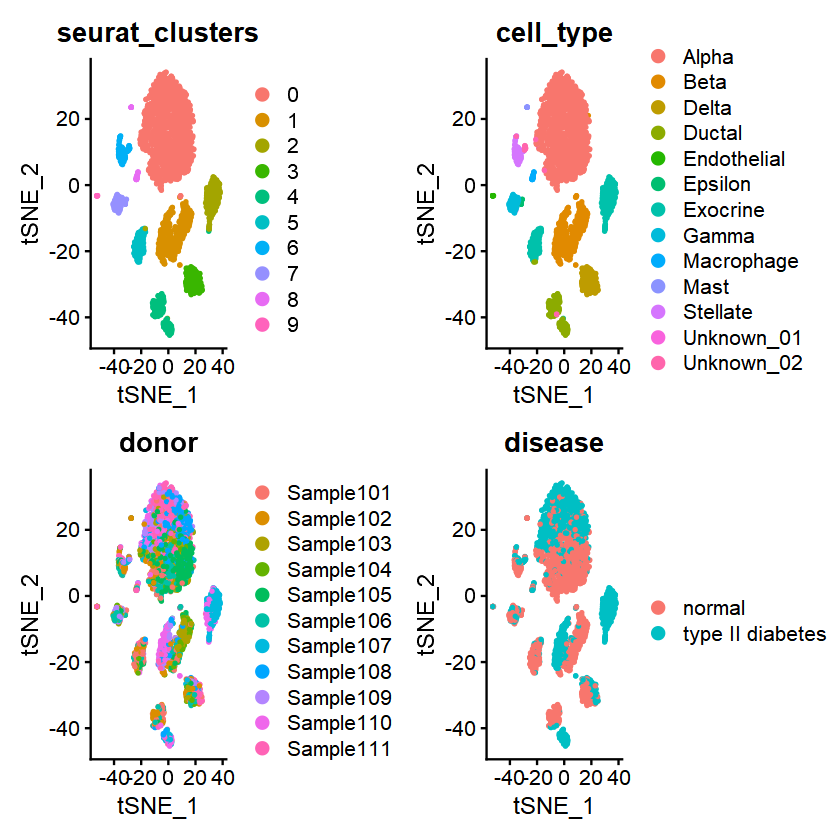

In [5]:
tsne_cluster + tsne_cell + tsne_donor +  tsne_disease + plot_layout(2,2)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


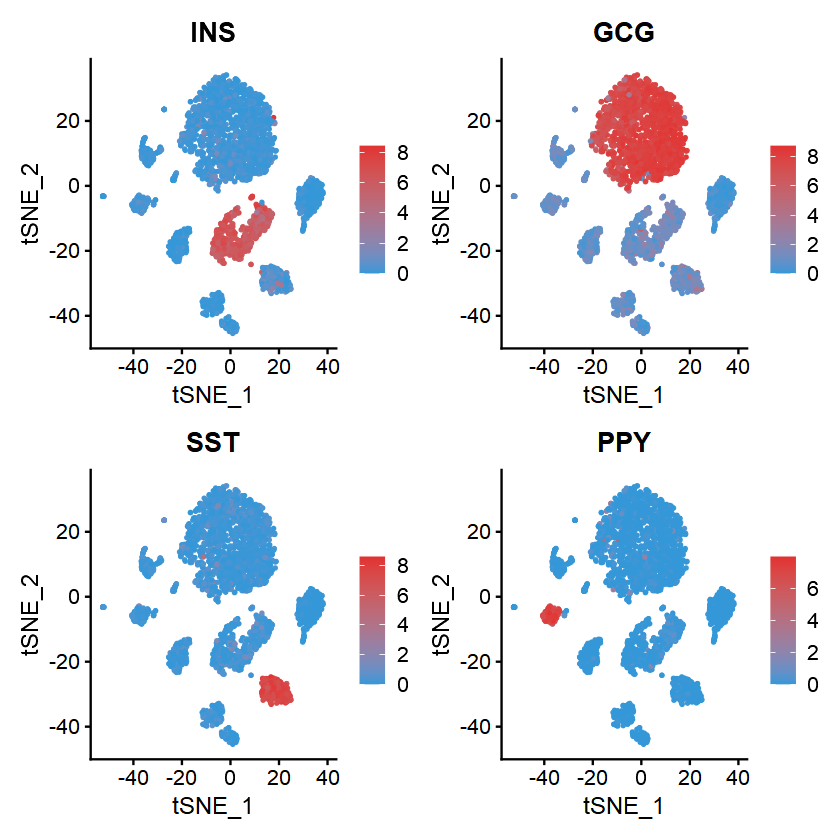

In [6]:
genes = c("INS","GCG","SST","PPY")
FeaturePlot(scdata_filter, features = genes,reduction = "tsne") & scale_color_gradient(low = "#3497d8",high = "#e23232")